In [1]:
import os
import sys
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()

# 저장 구조형태 살펴보기

In [2]:
dataset_path = "/opt/ml/input/data"
anns_file_path = dataset_path + "/train_all.json"

In [3]:
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())
    
print(type(dataset))

<class 'dict'>


In [4]:
dataset.keys()

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])

In [5]:
info = dataset['info']
licenses = dataset['licenses']
images = dataset['images']
categories = dataset['categories']
annotations = dataset['annotations']

In [6]:
print(type(info))
print(type(licenses))
print(type(images))
print(type(categories))
print(type(annotations))

<class 'dict'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [7]:
print("category count : ", len(categories))
print("images count : ", len(images))
print("annotations count : ", len(annotations))

category count :  11
images count :  3272
annotations count :  26400


# 전체 카테고리의 분포

In [8]:
nr_cats = len(categories)
nr_annotations = len(annotations)
nr_images = len(images)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 26400
Number of images: 3272


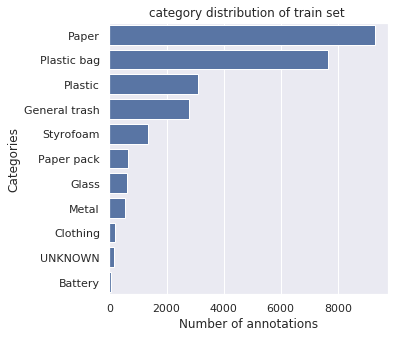

In [9]:
cat_histogram = np.zeros(nr_cats, dtype = int)

for ann in annotations:
    cat_histogram[ann['category_id']] += 1
    
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

# 이미지 당 object 개수

In [10]:
from collections import defaultdict

image_segmentation = defaultdict(int)

for annotation in annotations:
    image_id = annotation["image_id"]
    image_segmentation[image_id] += len(annotation['segmentation'])
    

In [11]:
print(max(image_segmentation.values())) # 최대 segment개수

181


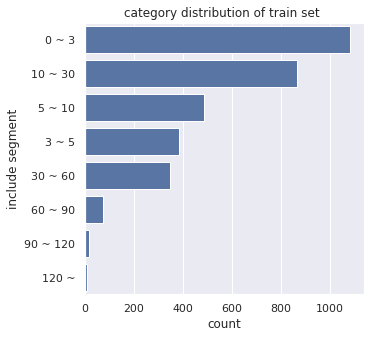

In [12]:
# image_length
image_segmentation_count = np.zeros(8, dtype = int)
image_segmentation_count_label = np.array(['0 ~ 3','3 ~ 5', '5 ~ 10','10 ~ 30', '30 ~ 60', '60 ~ 90', '90 ~ 120', '120 ~'])

for k,v in image_segmentation.items():
    if v>= 0 and v < 3:
        image_segmentation_count[0] += 1
    elif v>= 3 and v < 5:
        image_segmentation_count[1] += 1
    elif v>= 5 and v < 10:
        image_segmentation_count[2] += 1
    elif v>= 10 and v < 30:
        image_segmentation_count[3] += 1
    elif v>= 30 and v < 60:
        image_segmentation_count[4] += 1
    elif v>= 60 and v < 90:
        image_segmentation_count[5] += 1
    elif v>= 90 and v < 120:
        image_segmentation_count[6] += 1
    elif v>= 120:
        image_segmentation_count[7] += 1

    
    

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'include segment': image_segmentation_count_label, 'count': image_segmentation_count})
df = df.sort_values('count', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="count", y="include segment", data=df, label="Total", color="b")



# 이미지 마스킹 보기

In [13]:
import sys
sys.path.append('/opt/ml/pstage3')

In [14]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [15]:
%matplotlib inline

dataset_path = '/opt/ml/input/data'
anns_file_path = dataset_path + '/' + 'train_all.json'

with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 26400
Number of images: 3272


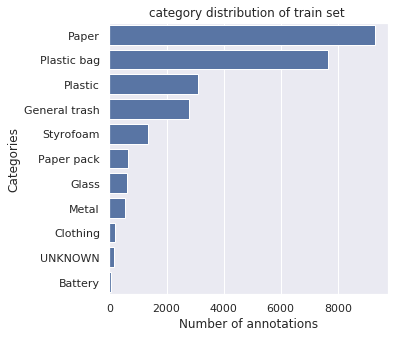

In [16]:
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

f, ax = plt.subplots(figsize=(5,5))

df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [17]:
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [18]:
# class (Categories) 에 따른 index 확인 (0~11 : 총 12개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,160.0
2,General trash,2782.0
3,Paper,9311.0
4,Paper pack,659.0
5,Metal,562.0
6,Glass,610.0
7,Plastic,3090.0
8,Styrofoam,1343.0
9,Plastic bag,7643.0


In [19]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0 # 픽셀 정규화 과정 - 추후 test set기준으로 정규화 작업 진행
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        return len(self.coco.getImgIds())

In [39]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train_all.json'

# batch size를 위한 함수
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=1.0),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)                  
        ], p=0.8),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.8),    
    A.RandomGamma(p=0.8),
    A.RandomRotate90(p=0.5),
    ToTensorV2()]
)

train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=8,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

loading annotations into memory...
Done (t=5.54s)
creating index...
index created!


# 세부사항 확인

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'General trash', 2}, {3, 'Paper'}, {'Plastic', 7}]


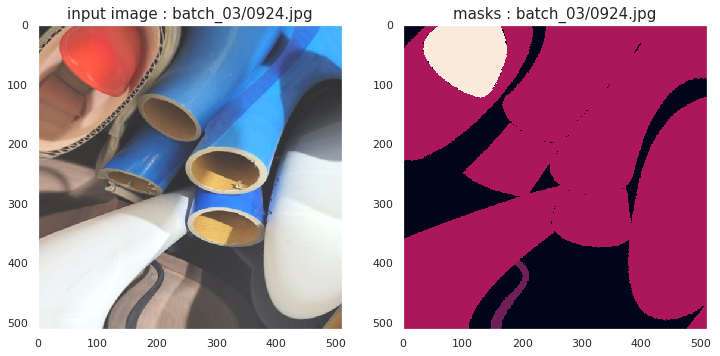

In [52]:
# val_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

# 전체 데이터 확인

In [ ]:
def show_images(images_info, temp_images, temp_masks, title = 'Segment image'):
    fig, axs = plt.subplots(nrows=len(temp_images) // 2, ncols=4, figsize=(20, 20))
    
    for check in range(len(temp_masks)):
        print("picture : ", check)
        print('Unique values, category of transformed mask : \n', 
              [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[check]))]
             )
        print("=======================================================\n")

    for i in range(len(temp_images) // 2):
        axs[i][0].imshow(temp_images[i*2].permute([1,2,0]))
        axs[i][0].grid(False)
        axs[i][0].set_title("input image : {}".format(image_infos['file_name']), fontsize = 12)
        axs[i][0].axis('off')

        axs[i][1].imshow(temp_masks[i*2])
        axs[i][1].grid(False)
        axs[i][1].set_title("masks : {}".format(image_infos['file_name']), fontsize = 12)
        axs[i][1].axis('off')
        
        axs[i][2].imshow(temp_images[i*2+1].permute([1,2,0]))
        axs[i][2].grid(False)
        axs[i][2].set_title("input image : {}".format(image_infos['file_name']), fontsize = 12)
        axs[i][2].axis('off')

        axs[i][3].imshow(temp_masks[i*2+1])
        axs[i][3].grid(False)
        axs[i][3].set_title("masks : {}".format(image_infos['file_name']), fontsize = 12)
        axs[i][3].axis('off')
    
    plt.show()
        

picture :  0
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'General trash', 2}, {'Paper', 3}, {'Plastic', 7}, {9, 'Plastic bag'}]

picture :  1
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Paper', 3}, {'Metal', 5}, {9, 'Plastic bag'}]

picture :  2
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {9, 'Plastic bag'}]

picture :  3
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {9, 'Plastic bag'}]

picture :  4
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Metal', 5}]

picture :  5
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {11, 'Clothing'}]

picture :  6
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Paper', 3}, {'Plastic', 7}]

picture :  7
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'General trash', 2}, {'Paper', 3}, {4, 'Paper pack'}, {'Plastic', 7}, {9, 'Plastic bag'}]



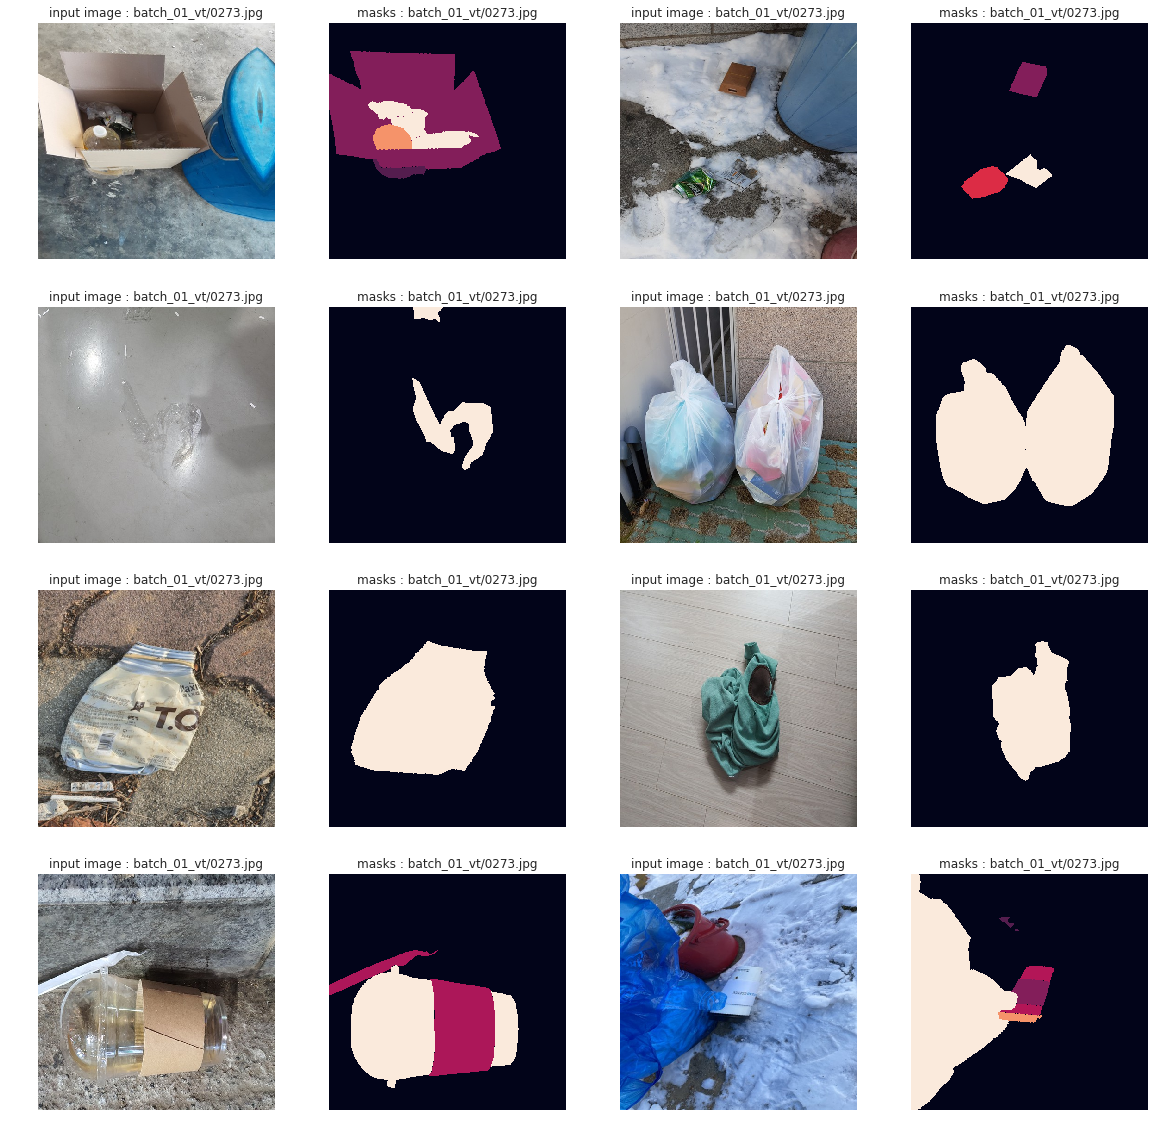

In [252]:
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

show_images(image_infos, temp_images, temp_masks)   

In [177]:
temp_masks[0].shape

torch.Size([512, 512])

# 카테고리별 표시 색(vmin, vmax으로 추후 해결) -> 결과 분석 시각화 파일에서 적용

In [178]:
category_names = list(sorted_df.Categories)

In [179]:
category_names

['Backgroud',
 'UNKNOWN',
 'General trash',
 'Paper',
 'Paper pack',
 'Metal',
 'Glass',
 'Plastic',
 'Styrofoam',
 'Plastic bag',
 'Battery',
 'Clothing']

In [180]:
pixel_value = category_names.index('Glass')

In [181]:
pixel_value_dict = {}

for name in category_names:
    pixel_value_dict[name] = category_names.index(name)

In [182]:
pixel_value_dict

{'Backgroud': 0,
 'UNKNOWN': 1,
 'General trash': 2,
 'Paper': 3,
 'Paper pack': 4,
 'Metal': 5,
 'Glass': 6,
 'Plastic': 7,
 'Styrofoam': 8,
 'Plastic bag': 9,
 'Battery': 10,
 'Clothing': 11}

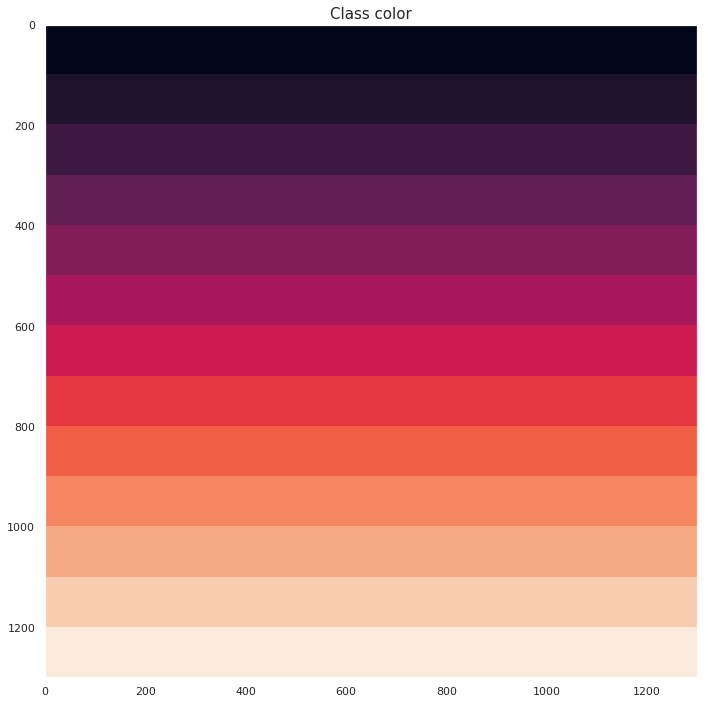

In [198]:
key_list = list(pixel_value_dict.keys())

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))

check_color = np.zeros((1300,1300))

for i in range(13):
    pixel_value = torch.tensor(i)
    for i in range(100 * i, 100 * (i+1)):
        check_color[i].fill(pixel_value)
        
ax1.imshow(torch.tensor(check_color))
ax1.grid(False)
ax1.set_title("Class color", fontsize = 15)

plt.show()

In [152]:
temp = np.zeros((200,200),dtype=int)

In [126]:
temp.fill(1)

In [127]:
temp

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])